# Part 3 : Restoration

In this part of the TP, we are going to look at image restoration. We will look at several type of noise and ways to remove this noise. We first define some helper functions.

In [17]:
from matplotlib import pyplot as plt
import numpy as np 
import imageio
from skimage import color

is_colab = True

def read_image(file_name):
    img_color = imageio.imread(file_name)
    img_gray = color.rgb2gray(img_color)
    return img_gray,img_color
    
def write_image(img_in,file_name_out):
    imageio.imwrite(file_name_out, np.uint8(255.0*img_in))
    
def display_image(img_in):
    plt.figure(figsize=(10, 10))
    if (img_in.ndim == 2):
        plt.imshow(img_in,cmap='gray')
    elif (img_in.ndim == 3):
        # careful, in this case we supppose the pixel values are between 0 and 255
        plt.imshow(np.uint8(img_in))
    else:
        print('Error, unknown number of dimensions in image')
    return


--2022-12-01 16:22:23--  https://perso.telecom-paristech.fr/anewson/doc/images/palma.png
Resolving perso.telecom-paristech.fr (perso.telecom-paristech.fr)... 2a04:8ec0:0:a::89c2:16e3, 137.194.22.227
Connecting to perso.telecom-paristech.fr (perso.telecom-paristech.fr)|2a04:8ec0:0:a::89c2:16e3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 770583 (753K) [image/png]
Saving to: 'palma.png.5'

palma.png.5         100%[===================>] 752.52K  --.-KB/s    in 0.06s   

2022-12-01 16:22:23 (13.2 MB/s) - 'palma.png.5' saved [770583/770583]



(600, 800)

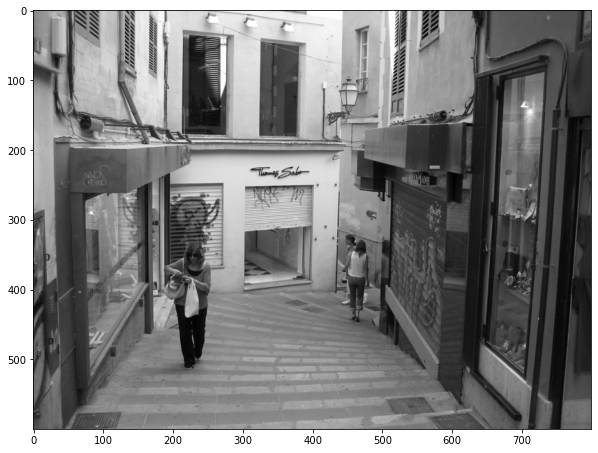

In [18]:

file_dir = 'images/'
file_name = 'palma'
file_ext = '.png'

if (is_colab == True):
  !wget "https://perso.telecom-paristech.fr/anewson/doc/images/palma.png"
  img_gray,_ = read_image(file_name+file_ext)
else:
  img_gray,_ = read_image(file_dir+file_name+file_ext)

display_image(img_gray)
img_gray.shape

We will look at the following noise types :

- Gaussian noise
- Impulse (salt-and-pepper) noise
- Missing pixels

Fill in the following functions to add this noise to a gray-level image. Do not forget to clip the pixe values to the range $(0,1)$.

In [19]:
import random
def add_gaussian_noise(img_in,sigma_noise):
  #INSERT CODE HERE
    noise = sigma_noise*np.random.normal(0,1,img_in.shape)
    img_out = img_in + noise

    return img_out


def add_impulse_noise(image,p):
    #output = np.zeros(image.shape,np.uint8)
    thres = p
    paper = 1-p
    salt = paper/2
    
    x,y = image.shape
    g = np.zeros((x,y), dtype=np.float32)
    compteur=0
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            rdn = random.random()
            if  salt < rdn < paper:
                g[i][j] = 0
            elif rdn <= salt :
                g[i][j] = 1
            if rdn<thres :
                g[i][j] = image[i][j]
                compteur+=1
    
    return g

def add_missing_pixels_noise(img_in,p):
    missing_pixel=np.random.binomial(1, p, img_in.shape)
    img_out = img_in*missing_pixel
    return img_out

Add the different noises to the input image, and display (or write) the results. Use the following parameters :

- sigma_noise=0.05 for the gaussian noise
- $p=0.9$ (the probability of a pixel __not__ being affected, for the impulse noise and missing pixels

In [20]:
img_gray1 = img_gray
#INSERT CODE HERE
img_gray_gaussian = add_gaussian_noise(img_gray1, 0.05)
write_image(img_gray_gaussian,file_name+'_gaussian_noise.png')

In [21]:
img_gray2 = img_gray
#INSERT CODE HERE
img_gray_impulse = add_impulse_noise(img_gray2,p=0.9)
write_image(img_gray_impulse,file_name+'_impulse_noise.png')


In [22]:
img_gray3 = img_gray
#INSERT CODE HERE
img_gray_missing = add_missing_pixels_noise(img_gray3,0.9)
write_image(img_gray_missing,file_name+'_missing_pixels.png')

__Question 3.1__ For each type of noise, propose a restoration filter (see course slides) 

__Answer__
- Gaussian noise : smoothing filter/Gaussian filter
- Impulse noise : median filter
- Missing Pixel : median filter

Implement these restoration techniques in appropriately named functions, and write the corresponding output images. Try to find the parameters which give the best results (visually).

__Note__, you can use the filtering functions of the ``scipy.ndimage`` package, where the filtering is already implemented

In [23]:
from scipy import ndimage
from scipy.ndimage import gaussian_filter
from scipy.ndimage import median_filter

def gaussian_filter(img,sigma):
  #INSERT CODE HERE
    img_out = ndimage.gaussian_filter(img,sigma)
    return img_out


def median_filter(img,median_size):
  #INSERT CODE HERE
    img_out = ndimage.median_filter(img, 3)
    return img_out



In [24]:
sigma_gauss = 5.0
img_out_gaussian = gaussian_filter(img_gray_gaussian,sigma_gauss)
write_image(img_out_gaussian,file_name+'_denoised_gaussian.png')


In [25]:
median_size = 3
img_out_impulse_median = median_filter(img_gray_impulse,median_size)
write_image(img_out_impulse_median,file_name+'_impulse_denoised_median.png')

In [26]:
img_out_missing_median = median_filter(img_gray_missing,median_size)
write_image(img_out_missing_median,file_name+'_missing_denoised_median.png')

__Question 3.2__ Roughly speaking, what is the tradeoff which you are trying to achieve by tuning the parameters ?

__Answer__ 
- Gaussian: The more sigma increases the more noise disappears, but the more sigma is high the less the image is sharp. We must therefore find a compromise between sharpness and noise.
- Impulse and missing: The more the median height increases, the more noise, missing pixels are found ... But less the image is sharp. 

### Evaluation

A commonly used metric for denoising is the ''Peak Signal-to-Noise Ratio'' (PSNR). This is linked to the commonly known mean squared error. The mean squared error is defined, for a reference image $Y$ and a restored image $Y$, of size $m \times n$ as :

- MSE$(Y,I) = \frac{1}{mn} \sum_{x,y} \left( I_{x,y} - Y_{x,y}\right)^2 $

The PSNR is defined, in Decibels, as :

PSNR$(Y,I) = 10 * \log{\left( \frac{I_{max}^2}{MSE(Y,I)} \right)}$,

where $I_{max}$ is the maximum value of the image. For us (normalised to 1), this gives :

PSNR$(Y,I) = -10 * \log{ \left({MSE(Y,I)} \right)}$.

Implement this in a function, and create a code to plot the PSNR for several values of the paramter, __in the Gaussian case only__. 

In [27]:
import pandas as pd
def PSNR(img,img_ref):  #img = I= img_ref & img_restored=Y= 
    size = len(img.flatten())
    mse = (1/size) * np.sum((img_ref-img)**2)
    psnr = 10 * np.log( ((img_ref.max())**2) /mse)
    return psnr



#INSERT CODE HERE
df = pd.DataFrame()
#df.columns = ['Sigma', 'PSNR']


for i in range(0,15):
    img_out_gaussian = gaussian_filter(img_gray_gaussian,i)
    psnr_gaussian = PSNR(img_out_gaussian,img_gray)
    d = {'Sigma': i , 'PSNR':psnr_gaussian }
    print(d)
    


{'Sigma': 0, 'PSNR': 59.91053099251055}
{'Sigma': 1, 'PSNR': 66.3831097152977}
{'Sigma': 2, 'PSNR': 58.8109615973071}
{'Sigma': 3, 'PSNR': 55.00589582192784}
{'Sigma': 4, 'PSNR': 52.55789545882869}
{'Sigma': 5, 'PSNR': 50.791426969339206}
{'Sigma': 6, 'PSNR': 49.429295737830316}
{'Sigma': 7, 'PSNR': 48.329388019472326}
{'Sigma': 8, 'PSNR': 47.41191304899773}
{'Sigma': 9, 'PSNR': 46.62902605480538}
{'Sigma': 10, 'PSNR': 45.949569502396095}
{'Sigma': 11, 'PSNR': 45.35150933749705}
{'Sigma': 12, 'PSNR': 44.81829129683284}
{'Sigma': 13, 'PSNR': 44.33704387965976}
{'Sigma': 14, 'PSNR': 43.897596645835854}


## Deconvolution

In this part of the TP, we are going to try and invert a convolution operation. This is called __deconvolution__, and can be carried out in the Fourier domain, as follows. For an image $I$, filter $f$ and an output $Y$, if we have :

$Y = I \ast f$,

then using the convolution theorem (see lesson), we have :

$I = \text{IFFT}\left(\frac{\hat{Y}}{\hat{f}}\right)$

where $\hat{Y}$ and $\hat{f}$ are the Fourier transforms of $Y$ and $f$ respectively.

To simplify the problem, we take a square image for this part of the TP.


--2022-12-01 16:39:00--  https://perso.telecom-paristech.fr/anewson/doc/images/boston.png
Resolving perso.telecom-paristech.fr (perso.telecom-paristech.fr)... 2a04:8ec0:0:a::89c2:16e3, 137.194.22.227
Connecting to perso.telecom-paristech.fr (perso.telecom-paristech.fr)|2a04:8ec0:0:a::89c2:16e3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 626414 (612K) [image/png]
Saving to: 'boston.png.7'

boston.png.7        100%[===================>] 611.73K  --.-KB/s    in 0.06s   

2022-12-01 16:39:00 (10.6 MB/s) - 'boston.png.7' saved [626414/626414]



(600, 600)

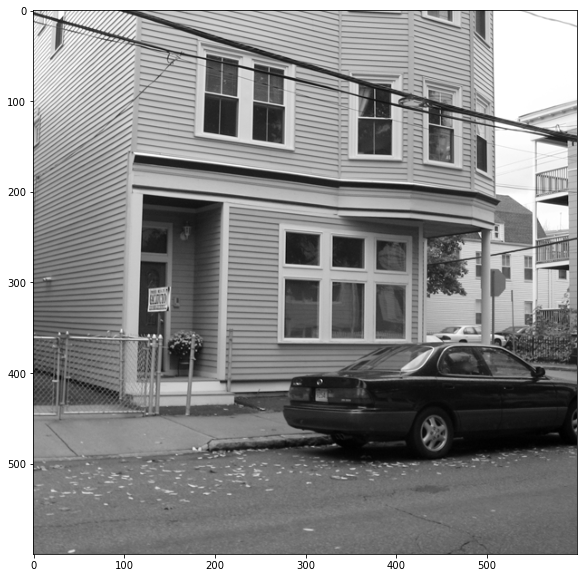

In [51]:
file_dir = 'images/'
file_name = 'boston'
file_ext = '.png'

if (is_colab == True):
  !wget "https://perso.telecom-paristech.fr/anewson/doc/images/boston.png"
  img_gray,_ = read_image(file_name+file_ext)
else:
  img_gray,_ = read_image(file_dir+file_name+file_ext)
img_gray.shape

display_image(img_gray)
img_gray.shape

Now, let us consider the following fiter, defined in the Fourier domain :

(600, 600)


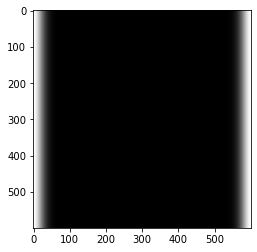

In [71]:
from scipy import signal

img_size = img_gray.shape[0]
h_size = int(np.floor(img_size/2.0))
f_hat = np.zeros((img_size,img_size))

X = np.asarray(range(-h_size,h_size))
f_hat = np.tile( np.expand_dims( np.exp(-( X**2) / (2.0*(20.0**2))) , axis=1), (1,img_size)).T
f_hat /= f_hat.sum()
f_hat = np.fft.ifftshift(f_hat)
plt.imshow( np.log( np.abs(f_hat)+1), cmap = 'gray')

print(f_hat.shape)

In [72]:
def display_spectrum(img):
    #INSERT CODE HERE
    tf =  np.fft.fft2(img)
    tf = np.fft.fftshift(tf)
    tf = np.log(1 + tf)
    plt.imshow(np.absolute(tf),cmap='gray')
    return tf

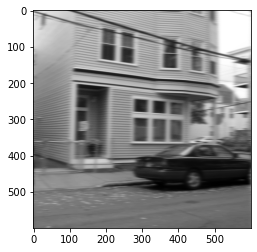

In [79]:
#INSERT CODE HERE
img_conv = np.fft.fft2(img_gray) * f_hat
img_conv = np.fft.ifft2(img_conv)
img_conv = np.real(img_conv)
img_conv = img_conv/img_conv.max()


plt.imshow(img_conv, cmap="gray")

array([[ 3.30624417e-13+1.27235530e-15j, -2.96429548e-14-2.29598767e-13j,
        -6.08402217e-13-1.39158274e-13j, ...,
         3.91686683e-13+5.80977649e-14j, -5.90971716e-13+1.52616463e-13j,
        -2.28705943e-14+2.36801781e-13j],
       [-3.66373598e-15+1.15936425e-14j, -3.93018951e-14-5.01047490e-14j,
         7.74935671e-14-8.77708261e-14j, ...,
        -1.09134923e-13-7.11440031e-15j,  4.79616347e-14-1.44090851e-13j,
         6.23945340e-14+2.95413566e-14j],
       [ 8.81517082e-14+2.14217688e-14j, -1.88737914e-14+7.88631396e-14j,
         2.79776202e-14-2.71082356e-14j, ...,
        -2.00950367e-14-3.12460071e-14j,  1.37667655e-14+1.57295826e-14j,
         4.21884749e-14-3.49983677e-14j],
       ...,
       [ 4.32986980e-14+5.39642952e-14j,  3.41948692e-14+3.69026992e-15j,
         6.15063556e-14+2.71092876e-14j, ...,
         2.15383267e-14+1.80828115e-15j, -2.50910404e-14+3.76219745e-14j,
         4.66293670e-15+1.40746602e-14j],
       [ 8.70414851e-14-2.08918860e-14j,  4.

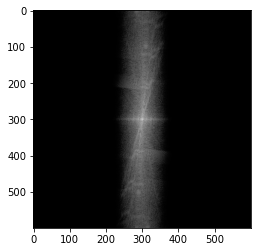

In [81]:
display_spectrum(img_conv)

__Question 3.3__ What does this filter do (you can use the visualisation method from the first part of the TP to see what the filter spectrum looks like) ? How can this happen in real life ? 

__Answer__ : 
- The spectrum shows that we keep the low frequencies in the vertical direction that represents the vertical edges.
- The image is blurred because we do not keep the high frequencies that correspond to the details of the image. We see the road well because it is a vertical axis.  

Now, create a function which carries out a deconvolution in the Fourier domain, given an image and the Fourier transform of the filter $\hat{f}$. You can reuse the code in the first part of the TP. Carry out the deconvolution on ``img_convolved`` and write the result to an output file. Remember to renormalise the output image.

__Important note__ : You will have a problem with very small values of $\hat{f}$ (division by 0). Propose a simple method to address this issue (look at the formula at the beginning of this section on deconvolution).


In [76]:
def deconvolve_fourier(img,f_hat):
    #INSERT CODE HERE
    epsilon = 1e-6
    f_hat_ = np.maximum(f_hat,epsilon)
    img_out= np.fft.fft2(img)/ f_hat_
    img_out = np.fft.ifft2(img_out)
    
    return img_out
    

img_out = np.real(deconvolve_fourier(img_conv,f_hat))
img_out -= img_out.min()
img_out /= img_out.max()


write_image(img_out,file_name+'_deconvolved.png')